# Wrapping Your Head Around Numerical Precision
_by Paul Schroeder_

# Introduction

In the field of scientific computing, one is frequently presented with a formula or expression that comes from the problem domain at hand. This could be something from a textbook that you're now transcribing into code to do something useful.

While the formula may undoubtedly be correct in theory and work fine for one-off calculations, there are times when it's necessary to make adaptations in order to account for issues arising from numerical stability or from problems innate to the formula itself. 

I recently encountered the following expression: $$\frac{\theta-sin(\theta)}{\theta^{3}}$$ This expression is for a coefficient that's part of a greater expression which converts between different representations of 3D transformation. $\theta$ is an unsigned angle.

Using the formula blindly resulted in a number of different issues, often producing wildly inaccurate values.

## The first, obvious problem

Upon brief inspection of the expression, it should be clear the expression's value is indeterminate when $\theta = 0$. In the limit as $\theta$ approaches zero, the expression neither blows up nor goes to zero, and in this case the limit is useful stand-in for the expression at zero even if the expression doesn't technically have a value. Below is a plot of the function from $[-\pi, \pi]$.

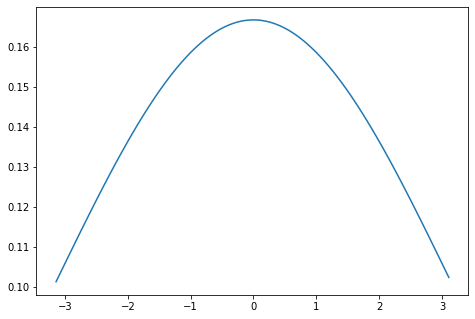

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math

coeff_fn = lambda x : (x - np.sin(x)) / (x**3)

theta_full = np.arange(-math.pi, math.pi, 0.05)
coeff_full = coeff_fn(theta_full)

full_range_plot = plt.figure();
full_range_axes = full_range_plot.add_axes([0, 0, 1, 1])
full_range_axes.plot(theta_full, coeff_full)

As you can see, the function has looks pretty well behaved. In fact it looks a lot like a parabola (it's not). The only issue so far is the value at zero which is indeterminate. This is what's known as a [removable discontinuity](https://mathworld.wolfram.com/RemovableDiscontinuity.html). 

The "value" of the expression at zero is of interest to us so let's compute the limit.

$$
\lim_{\theta \to 0} \frac{\theta-sin(\theta)}{\theta^{3}}
$$

If we plug in $\theta = 0$ we'll get 

$$
\lim_{\theta \to 0} \frac{\theta-sin(\theta)}{\theta^{3}} = \frac{0}{0}
$$

We have what's referred to as an "indeterminate form" of limit and thus this is a candidate for using [L'Hopital's Rule](https://en.wikipedia.org/wiki/L%27H%C3%B4pital%27s_rule). L'Hopital's rule is used in certain cases where the limit of an expression exists but can't be determined simply by evaluating the expression. To apply L'Hopital's rule we'll successively differentiate both the numerator and the denominator until the expression is no longer indeterminate and we can get an actual value. We'll use SymPy to do this. The `f.limit(x, 0)` function will evaluate the limit of the expression `f` as symbol `x` goes to zero, or you can manually use the `diff(f, x)` function to differentiate expression `f` with respect to `x` and `f.subs(x, 0)` to evaluate a resulting expression at `x=0`.

In [2]:
import sympy as sp
from IPython.display import Latex

t = sp.symbols('theta')

f = (t-sp.sin(t))
g = t**3
display(Latex("$$f(\\theta) = {}$$".format(sp.latex(f))))
display(Latex("$$g(\\theta) = {}$$".format(sp.latex(g))))
display(Latex("$$\\frac{f(0)}{g(0)} = \\frac{0}{0}$$"))

print('\nFirst round of L\'Hopital:')

fp = sp.diff(f, t)
gp = sp.diff(g, t)
display(Latex("$$f\'(\\theta) = {}$$".format(sp.latex(fp))))
display(Latex("$$g\'(\\theta) = {}$$".format(sp.latex(gp))))
display(Latex("$$\\frac{f\'(0)}{g\'(0)} = \\frac{0}{0}$$"))

print('-> This is still 0/0')
print('\nSecond round of L\'Hopital:')

fpp = sp.diff(fp, t)
gpp = sp.diff(gp, t)
display(Latex("$$f\'\'(\\theta) = {}$$".format(sp.latex(fpp))))
display(Latex("$$g\'\'(\\theta) = {}$$".format(sp.latex(gpp))))
display(Latex("$$\\frac{f\'\'(0)}{g\'\'(0)} = \\frac{0}{0}$$"))

print('-> This is still 0/0')
print('\nThird round of L\'Hopital:')

fppp = sp.diff(fpp, t)
gppp = sp.diff(gpp, t)
display(Latex("$$f\'\'\'(\\theta) = {}$$".format(sp.latex(fppp))))
display(Latex("$$g\'\'\'(\\theta) = {}$$".format(sp.latex(gppp))))
display(Latex("$$\\frac{f\'\'\'(0)}{g\'\'\'(0)} = \\frac{cos(0)}{6} = \\frac{1}{6}$$"))
print('Manual L\'Hopital\'s rule:', (fppp/gppp).subs(t, 0))

# Or just let SymPy do it's thing
c = f/g
print('From sp.Limit(): ')
c.limit(t, 0)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


First round of L'Hopital:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-> This is still 0/0

Second round of L'Hopital:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-> This is still 0/0

Third round of L'Hopital:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Manual L'Hopital's rule: 1/6
From sp.Limit(): 


1/6

So as we can see the function approaches $\frac{1}{6}$ as $\theta \rightarrow 0$. When implementing this expression in code, a plausible strategy for ensuring it behaves well for all inputs is to replace it with $\frac{1}{6}$ when $\theta$ (which in context is non-negative) drops below some threshold. So how do we choose the threshold? We only know the function behaves poorly at $\theta = 0$, but presumably it'll start failing at magnitudes slightly larger than zero (because we'll be nearly dividing by zero). One strategy to find a good threshold would be to search for successively smaller values of $\theta$ until the result of the expression converges to $\frac{1}{6}$ to within machine precision. Using a larger threshold will introduce some avoidable error since the function has measurably not reached $\frac{1}{6}$. Using a smaller threshold would provide no benefit since any improvement in accuracy would be inexpressible with the given float type and it would bring us closer to the point at which the function starts behaving poorly. This approach works well for plenty of expressions, but does have the downside that it may not be portable across: different platforms (e.g. x86 vs ARM), different compilers and optimization levels, and different types of floating point (e.g. `float` vs `double`).

## The second, less-obvious problem

While the approach we just laid out might seem sensible, it doesn't work for this function. It turns out that this function starts behaving poorly for values that aren't even that small. 

In the next code block, we generate an exponential sequence of smaller-and-smaller values of $\theta$ (`1e0, 1e-1, 1e-2, ...`) and apply them to the function. For 32-bit floats, the result starts deviating dramatically starting at $\theta = 10^{-2}$. 64-bit floats fare a bit better but eventually start producing zeros and NaNs which clearly are going to cause problems. In the Rust code I had initially implemented this function in, the function also starting oscillating between wildly large numbers and wildly small numbers. The difference probably has something to do with optimizations or the choice of floating-point rounding mode, but either way it's bad: we hit numerical issues well before reaching the problems caused by the removable discontinuity, meaning that we can't just replace the function with the limit ($1/6$) at some threshold. 

In [3]:
# Hide warnings
import warnings
warnings.filterwarnings('ignore')

small_thetas_32 = 10.0**np.flip(np.arange(-120.0, 0.0, 1, dtype=np.float32))
small_coeffs_32 = coeff_fn(small_thetas_32)
small_thetas_64 = 10.0**np.flip(np.arange(-120.0, 0.0, 1, dtype=np.float64))
small_coeffs_64 = coeff_fn(small_thetas_64)
print(small_coeffs_32)
print(small_coeffs_64)


[0.16658007 0.16670676 0.1164153  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.                nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan

### Interlude: Why do we care about small values?

With 64-bit floats, this function starts misbehaving at relatively small values of $\theta$. While a $10^{-5}$ radian rotation would indeed be small, it can produce large movements at larger distances from the origin. Moreover, the context for use of this function was an iterative pose estimation algorithm. If we were to say that rotations this small were equivalent to no rotation at all, we'd run into a few issues. As the estimation converges, the updates to the rotation get successively smaller. By clamping rotations below some threshold to zero, we'd limit how precise an answer we can get. Also the optimization algorithm we're using sometimes takes very small steps at the start of optimization. If the step were sufficiently small and we treated it as zero, we would not see any improvement in our cost function! That may cause the algorithm to assume we've converged, or to reset and take an even smaller step, never making any progress. 

It's worth noting that, in practice, this only occurred in tests with synthetic data. But synthetic data is based in real-world scenarios, after all, and it caused a lot of confusion. 

### Characterizing the Error Numerically

Clearly we should try to figure out what's going on. It would be useful to characterize the error we're seeing, so let's start there. The error here is the difference between the true value (i.e. computed with no numerical error) of the function and what we get when we try to compute it with a computer. This presents a tricky issue: we need to compute the true value to evaluate error, but if we had a way to compute the true value (within machine precision) of the function, we wouldn't have any problem at all! The fact that we don't have a way to compute the true value makes it hard to calculate the error. 

To get around this, we'll use an arbitrary precision library called `mpmath` and simply crank up the precision until our problem is (mostly) mitigated. In some cases, this can be the approach you take to solving this type of issue. However, this will cause runtime performance to tank, memory usage to skyrocket and you'll have all the practical difficulties of replacing a well-supported, built-in floating point type with a third-party one. It's best to address your numerical issues in more fundamental way than simply throwing more bits at the problem, if you can (which we'll do soon).

In [4]:
from mpmath import mp

# Let's start by generating a range of theta values with finer steping (every 1e-2 for the exponent, 10^0, 
# 10^-0.01, 10^-0.02 etc.). Although we're going to use `mpmath` later, it's important that we start with float64 
# values because that's the type it'll have in practice. Theta will be the float64 result of some earlier 
# calculation performed on float64s. If we generated Theta using mpmath, we might incur additional rounding which
# will skew the error calculation

# Starts at 1 and gets exponentially smaller and smaller
small_thetas_64_fine = 10.0**np.flip(np.arange(-120.0, 0.0, 1e-2, dtype=np.float64))

# Let's throw a lot of precision at this: 500 decimal places
mp.dps = 500

# This is the expression of interest but calculated using 500 decimal place of precision
mp_coeff_fn = lambda x : (mp.mpf(x) - mp.sin(mp.mpf(x))) / (mp.mpf(x)**mp.mpf(3))
vectorized_coeff_fn = np.vectorize(mp_coeff_fn)
coeffs_mp = vectorized_coeff_fn(small_thetas_64_fine)

print (coeffs_mp)

[mpf('0.15888697021424143009370201101939118792444144176337485762001073156377336463062438669033727365154206027497152001953607760416835704814586583247319692635043031210142028391511455227663976406122041488285968099906479872288670569846146455769539016848842705759912575480558061474741738148476380415409073858566262251678856320663076160978377914829929014341508480944975596679847797872252053133824152576768283651956398037074035892353896440546214110253472345564817136318662525454727927774272954190019849826840139954148')
 mpf('0.1592295356254086004511328832135512919938537271029944238648536031641376084527530747497208078315658484515877640612088335503365006538182649335065587476023924042720065971005082221321568758711741974238050627605976656933559500284296063507908410613569562405612645190696814656591880101575935162245607609143792436197593567087339924869910927592283191265803370738933085931369764286911849901483860811149482652700382104376072606911700895897528630694612938422419369849681317318069165868888834

As we can see here, the values computed with 500 decimal places of precision do in fact get exceedingly close to $\frac{1}{6}$. The choice of 500 wasn't especially rigorous but hopefully it's enough that we've well exceeded the machine precision for a 64-bit float for these values. 

Now let's compare the arbitrary precision results with the Float64 result.

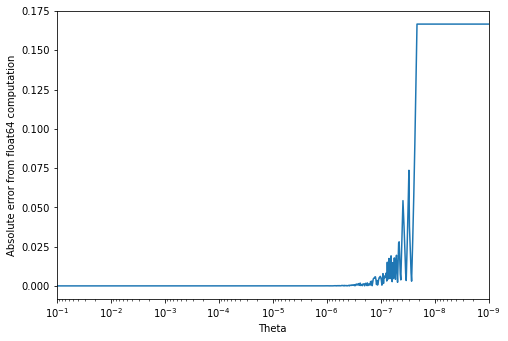

In [5]:
small_coeffs_64_fine = coeff_fn(small_thetas_64_fine)

# The error itself is computed with arbitrary precision so we don't get any additional conversion error
error_64 = np.array([mp.fabs(mp.mpf(coeff_f64) - coeff_mp) for (coeff_f64, coeff_mp) in zip(small_coeffs_64_fine, coeffs_mp)])

error_range_plot = plt.figure();
error_range_axes = error_range_plot.add_axes([0, 0, 1, 1])

error_range_axes.set_xscale('log')
error_range_axes.set_xlim(1e-1, 1e-9)
error_range_axes.set_xlabel('Theta')
error_range_axes.set_ylabel('Absolute error from float64 computation')
error_range_axes.plot(small_thetas_64_fine[0:10000], error_64[0:10000])

The magnitude of the error is shown here with $\theta$ getting exponentially smaller using a log-plot. While the error is pretty erratic, there does seem to be some sort of macro trend in the amount of error before the function starts returning zeros, NaNs etc. at which point the error clamps to `0.166666`

### Characterizing the Error Analytically

As random as floating point can feel sometimes, all of this is governed by well-defined standards (e.g. IEEE 754) and we should be able to analytically characterize the error we're getting here. 

Without getting too into the weeds on floating point formats, we'll start by simplifying noting that IEEE754 floats use a representation similar to scientific notation but with a base of 2 instead of 10 (so something like $d * 2^{e}$). A fixed number of bits is used to represent the decimal portion and the exponent. Given this restriction, the precision of this floating point format scales with the range of value being stored (precision being the difference between adjacent representable values). The difference between 1.0 as represented by a double and the next largest value will be very small (something like $10^{-16}$), whereas the difference between $2^{52}$ and the next largest value will be much larger (1.0). 

> The reality is, of course, more complicated with normalized values, a sign bit, biased exponents, and special cases for infinity, NaN and very small values, but this model should suffice for this explanation. 

This brings us to what is perhaps the most fundamental source of error in floating point calculations: rounding, i.e. rounding the result of a calculation to a _representable floating point value_, not rounding to an integer. If you take a floating point value and perform some calculation on it, there is no guarantee that the result is representable as a float. In fact, it is exceedingly likely that the true value will fall somewhere between two representable values. This means that no matter how accurately the machine may otherwise perform a calculation, there will in general be some error incurred from storing the result as a float.

One may wish to quantify the amount of error incurred by a floating point operation. The sliding precision of the floating point formats means that the error incurred scales with the magnitude of the result of the operation. So computing $x^2$ for $x=10$ will be much more precise in terms of absolute error than at $x = 2^{52}$. If the computer could calculate the result of the operation perfectly (meaning it's as precise as the format allows) then the worst case error will happen when the result falls precisely halfway between two representable floating point values. The worst case absolute error in that case will be half the distance between the two representable values the result falls between. 

### ULP

Because that worst case error is a function of the magnitude of the result, it can be useful to talk about the error in relative terms. To do so we'll introduce a useful quantity called an [ULP](https://en.wikipedia.org/wiki/Unit_in_the_last_place) (units in last place). An ULP is simply the gap between two representable values at a given scale. This gives us a nice way to describe floating point rounding error in relative terms without having to know the scale. For example, IEEE 754 requires that basic arithmetic operations (+, -, \*, /) be performed exactly and rounded correctly. This means that the only error we'll get is from rounding the result. Thus we can say that basic arithmetic operations incur 0.5 ULPs of error. Talking about error this way has the added benefit of being independent of the precision of the floating point type used. For instance, multiplication incurs 0.5 ULPs regardless of whether we're using single or double. Not all operations incur 0.5 ULPs worst case; it's possible to do worse because of imprecision of the calculation. This is all very much platform/library/machine dependent.

By looking-up the relative errors on your platform and adding up ULPs, you can get a solid estimate of the error of your calculation. We'll do so here with our function, starting with just the numerator. 

$$\theta-sin(\theta)$$ 

It's important to point out that, since $\theta$ is itself a floating point result of calculation whose accuracy we're not concerned with, we won't count any rounding of $\theta$ itself. There is an interesting [theorem](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html#1173) which states that subtracting two floating point values which are within a scale of 2 of one another (i.e. $\frac{x}{2} < y < 2x$) incurs no rounding error. So for small values, all the error in this expression comes from computing sine. 

> This theorem is from the excellent paper "What Every Computer Scientist Should Know About Floating-Point Arithmetic" by David Goldberg, which I highly recommend reading to learn more about error analysis and floating point in general. 

According to [the glibc source](https://sourceware.org/git/?p=glibc.git;a=blob;f=sysdeps/ieee754/dbl-64/s_sin.c;hb=HEAD#l200) and this [stackoverflow answer](https://stackoverflow.com/questions/2284860/how-does-c-compute-sin-and-other-math-functions/14869358), `sin` will be nearly perfectly calculated and rounded (i.e. just over 0.5 ULPs) for the small values I'm looking at.

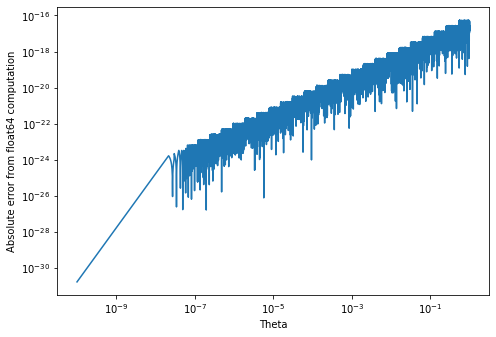

In [6]:
# Let's compute error for the numerator, but with a finer stepping and narrower range of values

# Even finer stepping
small_thetas_64_superfine = 10.0**np.flip(np.arange(-10, -0, 1e-3, dtype=np.float64))

# Compute result with arbitrary precision
mp_num_fn = lambda x : mp.mpf(x) - mp.sin(mp.mpf(x))
vectorized_num_fn = np.vectorize(mp_num_fn)
num_mp = vectorized_num_fn(small_thetas_64_superfine)

# Compute result with f64
f64_num_fn = lambda x : x - np.sin(x)
small_num_64_superfine = f64_num_fn(small_thetas_64_superfine)

# Compute error with arbitrary precision
error_64_superfine = np.array([mp.fabs(mp.mpf(f64) - mp_num) for f64, mp_num in zip(small_num_64_superfine, num_mp)])

error_range_plot = plt.figure();
error_range_axes = error_range_plot.add_axes([0, 0, 1, 1])
error_range_axes.set_xscale('log')
error_range_axes.set_yscale('log')
error_range_axes.set_xlabel('Theta')
error_range_axes.set_ylabel('Absolute error from float64 computation')
error_range_axes.plot(small_thetas_64_superfine, error_64_superfine)

When plotted on a log-log scale and at a finer stepping, the error plot has a pretty interesting shape. For the larger values, the worst-case error has a stair-step shape. This stair-stepping makes sense, as the absolute error corresponding to an ULP is also a step-wise function related to the integer-valued exponent of the value. 

We can model the upper-bound of error by calculating the absolute error corresponding to 0.5 ULPs from calculating sine.

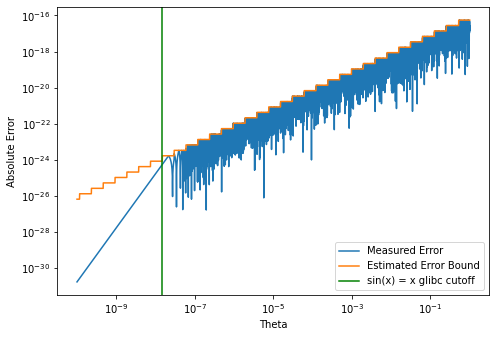

In [7]:
# ULP for a given value for float64 but calculated with arbitrary precision, see np.spacing() 
# in NumPy or eps() in Octave/Matlab for similar
f64_ulps_in_mp = lambda x: 2.0 ** (mp.floor(mp.mpf(1) + mp.log(x, b=2)) - 53)

# Calculate upper bound of error
est_error = [ f64_ulps_in_mp(mp.sin(mp.mpf(x))) * mp.mpf(0.5) for x in small_thetas_64_superfine]

error_range_plot = plt.figure();
error_range_axes = error_range_plot.add_axes([0, 0, 1, 1])
error_range_axes.set_xscale('log')
error_range_axes.set_yscale('log')

error_range_axes.plot(small_thetas_64_superfine, error_64_superfine, label='Measured Error')
error_range_axes.plot(small_thetas_64_superfine, est_error, label='Estimated Error Bound')
error_range_axes.axvline(2**(-26), label='sin(x) = x glibc cutoff', color='green')
error_range_axes.set_xlabel('Theta')
error_range_axes.set_ylabel('Absolute Error')
error_range_axes.legend()


It looks like our theoretical analysis matches what we're seeing empirically. For $\theta$ left of the green line (i.e. smaller), the `glibc` implementation of `sin(x)` defaults to `x`. Thus $x-sin(x)$ becomes $x-x$ which is precisely zero. The remaining error is the difference between the arbitrary precision answer and zero. 

So now let's consider the full expression. There's a number of operations taking place and the compiler has some leeway to restructure operations which may affect how much error we get, but let's make a reasonable guess. We'll assume that the emitted instructions first evaluate the numerator and denominator separately and then divide the two. I wrote a similar expression in C++ (https://godbolt.org/z/YGj7ac9Kf) and inspected the resulting assembly to find that is in fact what happens with a modern version of Clang, so let's roll with it.

We'll use the notation $()_{f}$ to denote the process of rounding to the nearest float and $\pm \delta_{?}$ to denote the error for a given operation.

So
$$ \frac{x-sin(x)}{x^3} $$
when evaluated with a computer becomes:
$$ (\frac{(x-(sin(x))_f)}{(x^3)_{f}})_{f} $$

As noted above, the subtraction in the numerator incurs no rounding error, just the error from computing $sin(x)$. On our platform, computing $x^3$ will be computed (nearly) exactly and rounded correctly as will the final division. Each of these will incur 0.5 ULPs. We can convert the rounding function to errors bounds.
$$ \frac{(x-sin(x)) \pm \delta_{sin(x)}}{x^3 \pm \delta_{x^3}} \pm \delta_{result} $$

In the denominator, $x^3$ will always greatly exceed $\delta_{x^3}$, so to simplify the expression we'll say that $x^3 \pm \delta_{x^3} \approx x^3$. Thus we'll have:
$$ \frac{(x-sin(x)) \pm \delta_{sin(x)}}{x^3} \pm \delta_{result} $$
$$ \frac{(x-sin(x))}{x^3} \pm (\frac{\delta_{sin(x)}}{x^3} + \delta_{result}) $$
For the small values of $\theta$ we're interested in, the error caused by rounding the final result will usually be small (0.5 ULP at 0.16666 = $1.3^{-17}$). However on some platforms I tested, the final result can be very large, in which case the round-off becomes more significant. For now we'll drop that term, since most of the error is caused by the other term.
$$ \frac{(x-sin(x))}{x^3} \pm \frac{\delta_{sin(x)}}{x^3} $$

And thus the error itself is approximated by:
$$ \frac{\delta_{sin(x)}}{x^3} $$

To sum up the effect here, the relatively small error caused by calculating $sin(x)$ and storing it as a float is greatly amplified when divided by $x^3$, which is _very_ small when $x$ is small.


Let's plot the theoretical and measured error to see if our analysis is correct.

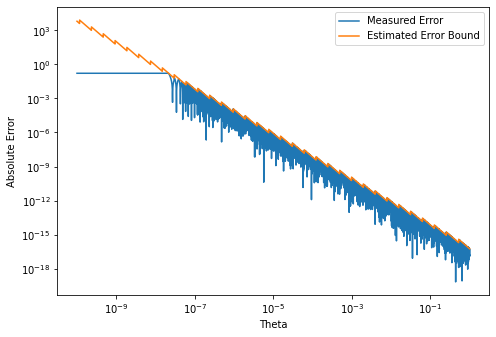

In [8]:
# Compute result with arbitrary precision
mp_coeff_fn = lambda x : (mp.mpf(x) - mp.sin(x)) / (x**3)
vectorized_coeff_fn = np.vectorize(mp_coeff_fn)
coeff_mp = vectorized_coeff_fn(small_thetas_64_superfine)

# Compute result with f64
coeff_fn = lambda x : (x - np.sin(x)) / (x**3)
small_coeff_64_superfine = coeff_fn(small_thetas_64_superfine)

# Compute estimated error bound
est_error = [ (f64_ulps_in_mp(mp.sin(x)) * mp.mpf(0.5)) / (x**3) for x in small_thetas_64_superfine]

# Compute error with arbitrary precision
error_64_superfine = np.array([mp.fabs(mp.mpf(f64) - mp_num) for f64, mp_num in zip(small_coeff_64_superfine, coeff_mp)])

error_range_plot = plt.figure();
error_range_axes = error_range_plot.add_axes([0, 0, 1, 1])
error_range_axes.set_xscale('log')
error_range_axes.set_yscale('log')
error_range_axes.set_xlabel('Theta')
error_range_axes.set_ylabel('Absolute Error')
error_range_axes.plot(small_thetas_64_superfine, error_64_superfine, label='Measured Error')
error_range_axes.plot(small_thetas_64_superfine, est_error, label='Estimated Error Bound')
error_range_axes.legend()

It appears our analytical error bound matches quite well until the $sin(x)$ gets replaced by $x$. Also note the slope of the error. Up to a point, the error gets worse as $\theta$ gets smaller. 

# Approximating the Function

We know that our function has a known discontinuity at zero, and has poor numerical behavior well before that point. To get around this, let's try replacing the function with an approximation. We'll use a Taylor series expansion about zero (i.e. a McLauren series), to approximate the function. A [Taylor Series](https://en.wikipedia.org/wiki/Taylor_series) allows us to evaluate a function at some point using an infinitely large (in number of terms) polynomial. We can approximate the function's value at the point by using a finite number of the polynomial terms.

Let's say there's some infinite series equal to our function
$$
\sum_{i=0}^{\infty}{a_i x^i} = \frac{x-sin(x)}{x^{3}} \\
x^3 \sum_{i=0}^{\infty}{a_i x^i} = x-sin(x)
$$
We'll replace $sin(x)$ with its [Taylor series expansion](https://en.wikipedia.org/wiki/Taylor_series#Trigonometric_functions)
$$
x^3 \sum_{i=0}^{\infty}{a_i x^i} = x-(x-\frac{x^3}{3!}+\frac{x^5}{5!}+\ldots)
$$
We'll cancel out $x$ and divide by $x^3$
$$
\sum_{i=0}^{\infty}{a_i x^i} = (\frac{x^0}{3!}-\frac{x^2}{5!}+\ldots)
$$
We'll collect these terms back into a summation
$$
\frac{x-sin(x)}{x^{3}} = \sum_{i=0}^{\infty}{\frac{(-1)^{n}}{(2n+3)!}x^{2n}}
$$

Since we only need to approximate the function in a narrow range around zero, we'll try approximating the function around $x=0$ with just two terms:

$$
\frac{x-sin(x)}{x^{3}} \approx \frac{1}{6} - \frac{x^{2}}{120}
$$

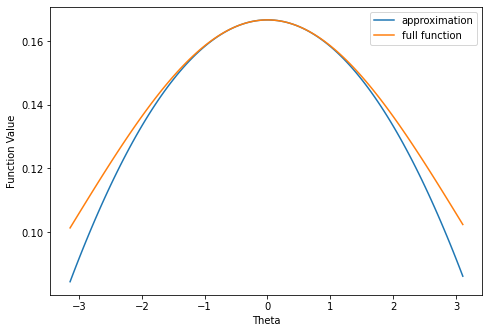

In [9]:
approx_coeff_fn = lambda x : (1/6) - x*x / 120

approx_coeff_full = approx_coeff_fn(theta_full)

approx_full_range_plot = plt.figure();
approx_full_range_plot = approx_full_range_plot.add_axes([0, 0, 1, 1])
approx_full_range_plot.plot(theta_full, approx_coeff_full, label='approximation')
approx_full_range_plot.plot(theta_full, coeff_full, label='full function')
approx_full_range_plot.set_xlabel('Theta')
approx_full_range_plot.set_ylabel('Function Value')
approx_full_range_plot.legend()

This looks like a good fit near zero, but clearly it starts diverging for larger values. What's left to do now is to choose a _threshold_ above which we use the full expression, and below which we use the approximation. A sensible strategy would be to choose the point at which the numerical error of the function exceeds the error of the approximation. For values smaller than this threshold, we'll use the approximation. We do have a way to compute an upper bound on error, so we could probably come up with a strategy to solve for the optimal threshold, but for now we'll just inspect the graph.

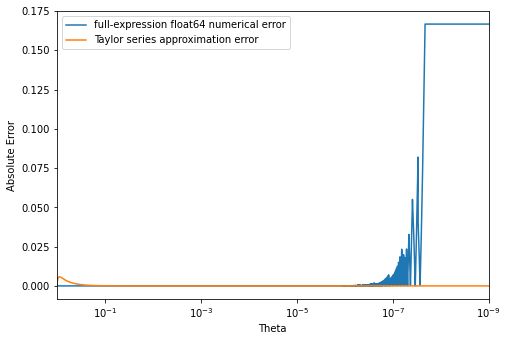

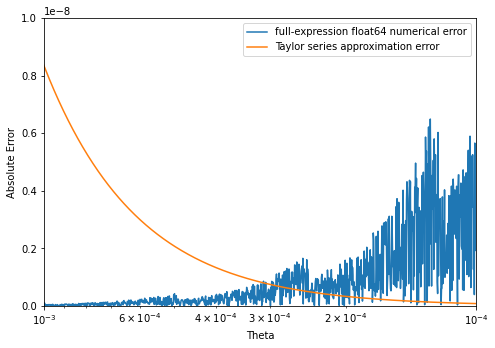

In [10]:
# Evaluate the approximation
small_coeffs_approx_64_superfine = approx_coeff_fn(small_thetas_64_superfine)

# Compute error
error_approx_64 = np.array([mp.fabs(approx_coeff - mp_coeff) for approx_coeff, mp_coeff in zip(small_coeffs_approx_64_superfine, coeffs_mp)])

# Plot error with wide range
error_range_plot_coarse = plt.figure();
error_range_axes_coarse = error_range_plot_coarse.add_axes([0, 0, 1, 1])

error_range_axes_coarse.set_xscale('log')
error_range_axes_coarse.set_xlim(1, 1e-9)
error_range_axes_coarse.plot(small_thetas_64_superfine[0:70000], error_64_superfine[0:70000], label='full-expression float64 numerical error')
error_range_axes_coarse.plot(small_thetas_64_superfine[0:70000], error_approx_64[0:70000], label='Taylor series approximation error')
error_range_axes_coarse.set_xlabel('Theta')
error_range_axes_coarse.set_ylabel('Absolute Error')
error_range_axes_coarse.legend()

# Plot error with narrow range
error_range_plot_fine = plt.figure();
error_range_axes_fine = error_range_plot_fine.add_axes([0, 0, 1, 1])

error_range_axes_fine.set_xscale('log')
error_range_axes_fine.set_xlim(1e-3, 1e-4)
error_range_axes_fine.set_ylim(0, 1e-8)
error_range_axes_fine.plot(small_thetas_64_superfine, error_64_superfine, label='full-expression float64 numerical error')
error_range_axes_fine.plot(small_thetas_64_superfine, error_approx_64, label='Taylor series approximation error')
error_range_axes_fine.set_xlabel('Theta')
error_range_axes_fine.set_ylabel('Absolute Error')
error_range_axes_fine.legend()

Looking closely at the zoomed in graph, we can see a good threshold would be around $3\cdot10^{-4}$. Anything larger would result in more approximation error and anything smaller would result in more numerical error. It's worth noting that the error will be highest at this point, with a value of around $10^{-9}$. If that were an unacceptable amount of error, one could add more Taylor series terms. That would push the approximation error curve down and to the left, meaning a larger range of input values would have an acceptable approximation error.

# Conclusion

In this notebook, we analyzed a mathematical function that was exhibiting problems when evaluating on a computer. We showed:
* how to use `SymPy` to evaluate the formula's limits at its removable continuities
* how to use the arbitrary precision library `mpmath` to evaluate floating point error
* how to calculate an expression for the upper bound on floating point error
* how to develop approximations to alleviate the problems

It may have been somewhat obvious to some readers that dividing an expression by $\theta^{3}$ for values of $\theta$ so close to zero would be problematic. However there are some less obviously-pathological expressions that exhibit problems as well. The [Quadratic equation](https://en.wikipedia.org/wiki/Quadratic_equation) is classic example of a function that exhibits a phenomenon called [Catastrophic Cancellation](https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html#700) for certain values. In that case, the problem can be fixed not by using an approximation but simply by rewriting the expression somewhat. Unfortunately that wasn't an option in this case.